In [8]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables
import fbpca

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
import CEMBA_clst_utils
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)
import plot_utils
importlib.reload(plot_utils)


<module 'plot_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/plot_utils.py'>

In [9]:
import datetime
today = datetime.date.today() #.strftime("%y%m%d")

logger = snmcseq_utils.create_logger()

output_figformat = (
    '/cndd2/fangming/projects/scf_enhancers/figures/'
    '{{}}_{}.pdf'.format(today)
    )
print(output_figformat)

print(today)

/cndd2/fangming/projects/scf_enhancers/figures/{}_2021-03-18.pdf
2021-03-18


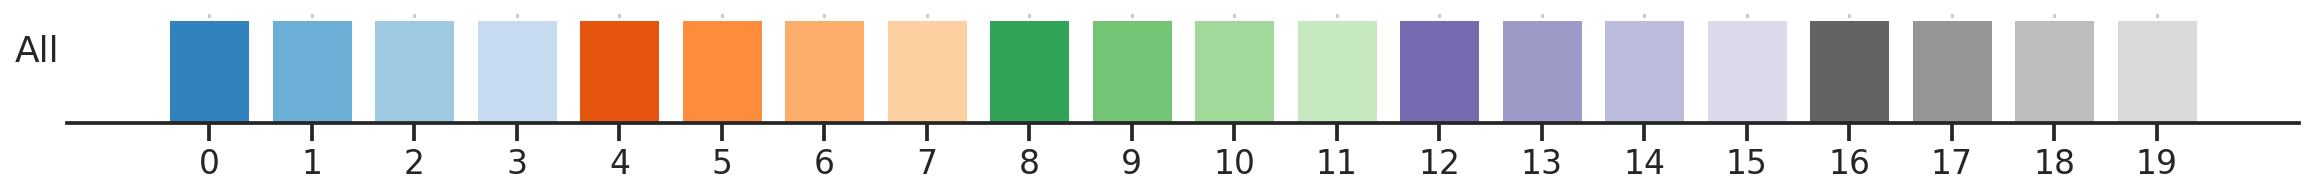

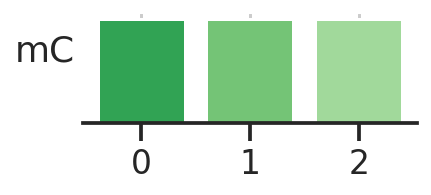

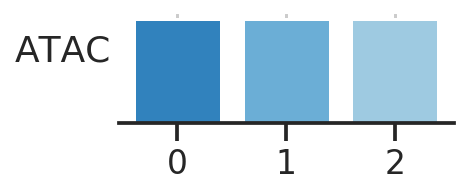

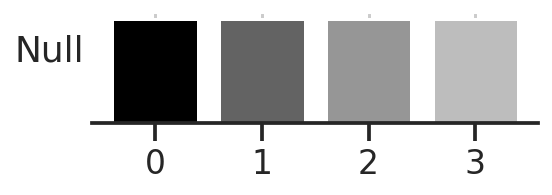

In [10]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

## Get gene by metacell tables 
- RNA
- mCG
- ATAC

In [11]:
# enhancer_gene_pairs
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
enh_gene_table = pd.read_csv(f, sep='\t')
print(enh_gene_table.shape)

(2589994, 18)


In [12]:

CLUSTER_COL = 'cluster_r'

def pipe_corr_analysis_atac(
        common_modx_cells, common_mody_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes, common_enhancer_regions,
        X, Y, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_modx_cells_updated = np.intersect1d(common_modx_cells, cell_cell_knn_xaxis)
    common_mody_cells_updated = np.intersect1d(common_mody_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_modx_cells, common_modx_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mody_cells, common_mody_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y = Y.tocsc()[:, y_idx]

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_modx_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mody_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_modx_cells_updated)

    logging.info("{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y.shape,))

    for clst_col in modx_clsts.columns: 
        logging.info(clst_col)
        if clst_col.startswith(CLUSTER_COL):
    #         output_corr = output_corrs.format(clst_col)
    #         if not force and os.path.isfile(output_corr):
    #             logging.info("skip {}, already exists...".format(output_corr))
    #             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))
                continue
            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # Dec 21,2020
            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # Dec 21,2020
            enh_lengths = pd.Series((common_enhancer_regions['end']-common_enhancer_regions['start']).values)
            # enhancer by metacell (counts)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_atac = Y.dot(knn_yz).todense() 
            # normalization (logTPM)
            ec_atac = snmcseq_utils.logtpm(pd.DataFrame(ec_atac), enh_lengths).values
            logging.info("{} {}".format(gc_rna.shape, ec_atac.shape,))

    #         # corr analysis
    #         output_corr = output_corrs.format(clst_col)
    #         (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    #             gc_rna, ec_atac, 
    #             common_genes, np.arange(len(ec_atac)),
    #             enhancer_gene_to_eval['gene'].values, 
    #             enhancer_gene_to_eval['ens'].values, 
    #             output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
    #             )
            return (
                gc_rna, ec_atac, 
                common_genes, np.arange(len(ec_atac)),
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
            )

def wrap_corr_analysis_atac(
        mod_x, mod_y, 
        input_name_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snatac_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_snatac_gene.npz',
    )


    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_modx_cells, common_mody_cells, 
     common_genes, common_enhancer_regions,
     X, Y, 
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(modx_clsts.shape, knn_xy.shape, 
                                          cell_cell_knn_xaxis.shape, 
                                          cell_cell_knn_yaxis.shape,
                                         )
                    )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

    return pipe_corr_analysis_atac(
                common_modx_cells, common_mody_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes, common_enhancer_regions,
                X, Y, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

def pipe_corr_analysis_mc(
        common_rna_cells, common_mc_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes,
        X, Y_cg, Y_mcg, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
    common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y_cg = Y_cg.tocsc()[:, y_idx]
    Y_mcg = Y_mcg.tocsc()[:, y_idx] 

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_rna_cells_updated)

    logging.info("{}_{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y_cg.shape, Y_mcg.shape))

    for clst_col in modx_clsts.columns: 
        if clst_col.startswith(CLUSTER_COL):
            
            logging.info(clst_col)
        
#         output_corr = output_corrs.format(clst_col)
#         if not force and os.path.isfile(output_corr):
#             logging.info("skip {}, already exists...".format(output_corr))
#             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))

            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # # normalization - such that metacells made of more cells still sums to 1
            # knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))
            # # gene by metacell
            # gc_rna = X.dot(knn_xz).todense() 

            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # enhancer by metacell (counts cg, mcg)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_cg = Y_cg.dot(knn_yz).todense() 
            ec_mcg = Y_mcg.dot(knn_yz).todense()  
            logging.info("{} {} {}".format(gc_rna.shape, ec_cg.shape, ec_mcg.shape))

            # mC
            ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                           pd.DataFrame(ec_cg).astype(np.float32), 
                                           pd.DataFrame(ec_mcg).astype(np.float32), 
                                           base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
            logging.info("{}".format(ec_mccg.shape))

#             # corr analysis
#             (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
#                 gc_rna, ec_mccg, 
#                 common_genes, ec_mccg.index.values,
#                 enhancer_gene_to_eval['gene'].values, 
#                 enhancer_gene_to_eval['ens'].values, 
#                 output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
#                 )
            return (
                gc_rna, ec_mccg, 
                common_genes, ec_mccg.index.values,
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
                )

def wrap_corr_analysis_mc(
        mod_x, mod_y, 
        input_nme_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snmcseq_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_mcg_snmcseq_gene.npz',
        'mat_cg_snmcseq_gene.npz',
    )

    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_rna_cells, common_mc_cells, 
     common_genes, common_enhancer_regions,
     X, Y_mcg, Y_cg, 
    #  knn_xy, knn_xx,
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(
              modx_clsts.shape, 
              knn_xy.shape, 
              cell_cell_knn_xaxis.shape, 
              cell_cell_knn_yaxis.shape,
              )
             )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
    return pipe_corr_analysis_mc(
                common_rna_cells, common_mc_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes,
                X, Y_cg, Y_mcg, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

In [5]:
mod_x, mod_y = '10x_cells_v3', 'snatac_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'

CLUSTER_COL = 'cluster_r25'
res1 = wrap_corr_analysis_atac(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
                            corr_type='spearmanr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna1, ec_atac = res1[:2]
print(gc_rna1.shape, ec_atac.shape)

mod_x, mod_y = '10x_cells_v3', 'snmcseq_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'
res2 = wrap_corr_analysis_mc(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
    #                         corr_type='pearsonr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna2, ec_mccg = res2[:2]
print(gc_rna2.shape, ec_mccg.shape)

03/09/2021 10:10:37 AM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
03/09/2021 10:10:37 AM <class 'numpy.ndarray'>_(135665,)_cell_snatac_gene.txt
03/09/2021 10:10:37 AM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
03/09/2021 10:10:37 AM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
03/09/2021 10:12:07 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
03/09/2021 10:12:11 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 135665)_mat_snatac_gene.npz
03/09/2021 10:12:13 AM (55862, 41) (55862, 43774) (55862,) (43774,)
03/09/2021 10:12:43 AM (55862, 43774)_(55862, 41)_(31053, 55862)_(233514, 43774)
03/09/2021 10:12:43 AM cluster_r1.0
03/09/2021 10:12:43 AM cluster_r1.2589254117941673
03/09/2021 10:12:43 AM cluster_r1.5848931924611136
03/09/2021 10:12:43 AM cluster_r1.9952623149688797
03/09/2021 10:12:43 AM cluster_r2.51188643150958
03/09/2021 10:12:43 AM cluster_r3.1622776601683795
03/09/2021 10:12:43 AM cluster_r3.981071705534973
03

(31053, 251) (233514, 251)


03/09/2021 10:13:01 AM <class 'numpy.ndarray'>_(9931,)_cell_snmcseq_gene.txt
03/09/2021 10:13:01 AM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
03/09/2021 10:13:01 AM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
03/09/2021 10:13:04 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
03/09/2021 10:13:37 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_mcg_snmcseq_gene.npz
03/09/2021 10:14:57 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_cg_snmcseq_gene.npz
03/09/2021 10:14:58 AM (55912, 41) (55912, 7499) (55912,) (7499,)
03/09/2021 10:15:13 AM (55912, 7497)_(55912, 41)_(31053, 55912)_(233514, 7497)_(233514, 7497)
03/09/2021 10:15:13 AM cluster_r25.11886431509581
03/09/2021 10:15:13 AM Number of metacells: 248
03/09/2021 10:16:05 AM (31053, 248) (233514, 248) (233514, 248)
03/09/2021 10:16:07 AM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/09/2021 10:16:08 AM (233512, 248)


(31053, 248) (233512, 248)


In [7]:
ec_mccg.tail()

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,246,247
233509,0.024564,0.020045,0.754647,0.636523,0.827143,0.880168,0.818412,0.857061,0.929900,0.667137,...,0.793713,0.800481,0.739035,0.822034,0.798982,0.040000,0.808732,0.870712,0.631757,0.750000
233510,0.827608,0.972543,0.996793,0.987494,0.872891,0.920969,0.883171,0.204075,0.925007,0.569387,...,0.524786,0.916499,0.823464,0.303293,0.538686,0.781482,0.904624,0.255034,0.594771,0.476744
233511,0.171004,0.069895,0.978632,0.994764,0.979430,0.971857,0.925962,0.891357,0.965318,0.911102,...,0.937132,0.989209,0.965630,0.981651,0.940803,0.293144,0.961102,0.887755,0.838150,0.830508
233512,0.943284,0.400000,0.989529,1.000000,1.000000,1.000000,1.000000,0.901667,1.000000,1.000000,...,0.909910,1.000000,0.914894,0.930818,0.880000,0.830303,1.000000,0.813433,1.000000,0.923077
233513,0.953065,0.892268,0.999457,1.000000,0.865772,0.650622,0.780350,0.994978,0.791262,0.316273,...,0.943452,0.867647,0.768987,0.949405,0.971503,0.928870,0.650206,0.992509,0.883178,0.837838


## analysis

- make sure enhancer index matches (yes)
- PCA on genes (scree plot)
- remove top ones
- regress RNA ~ mC/ATAC


In [8]:
y_gc = gc_rna2 - np.mean(gc_rna2, axis=0)
x_ec = ec_mccg


In [9]:
U, s, Vt = fbpca.pca(y_gc, k=min(y_gc.shape))
V = Vt.T
print(U.shape, s.shape, Vt.shape)

(31053, 248) (248,) (248, 248)


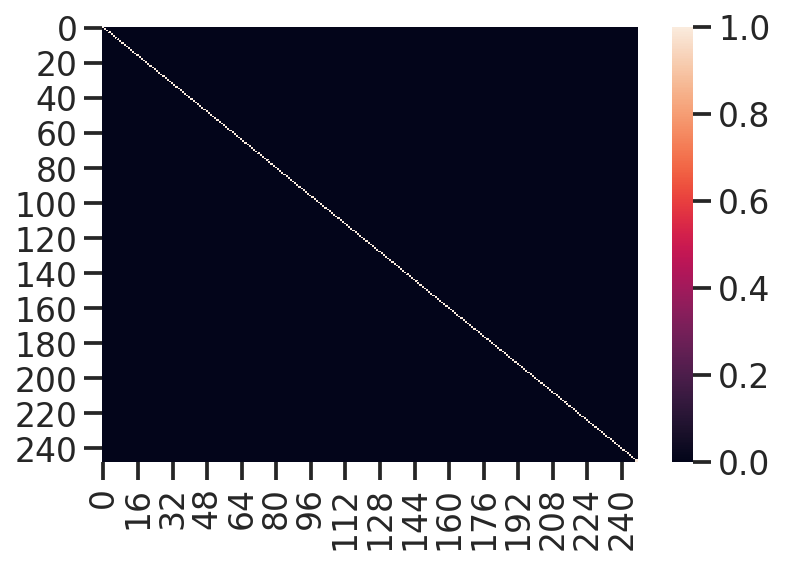

In [10]:
# sns.heatmap(Z.T.dot(Z))
sns.heatmap(V.dot(Vt))

In [11]:
Z = V.dot(np.diag(s))

In [12]:
y_gr = y_gc.dot(Z)
x_er = ec_mccg.dot(Z)
print(y_gr.shape, x_er.shape)

(31053, 248) (233512, 248)


In [13]:
def eval_scree(s, pcs_to_plot):
    """
    """
    scree = np.power(s, 2)/np.sum(np.power(s, 2))

    fig, ax = plt.subplots(1, 1, figsize=(1*5, 1*5))
    ax.set_title("PC1: {:.3f}".format(scree[0]))
    ax.plot(pcs_to_plot, scree[pcs_to_plot-1], '-o')
    ax.set_xlabel('Principal components')
    ax.set_ylabel('Fraction of variance')
    plt.show()

In [14]:
# regression (applied to each gene and enh pair) -- correlate gene-enh
configs = [
    (y_gc, x_ec, 'spearmanr', 'test_ols_mcrna_spearmanr_jan25.pkl'),
    (y_gc, x_ec, 'pearsonr', 'test_ols_mcrna_pearsonr_jan25.pkl'),
    
    (y_gr, x_er, 'spearmanr', 'test_gls_mcrna_spearmanr_jan25.pkl'),
    (y_gr, x_er, 'pearsonr', 'test_gls_mcrna_pearsonr_jan25.pkl'),
]

for config in configs:
    y, x, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    
    (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
        y, x,
        res2[2], res2[3],
        res2[4], res2[5],
        output_file=output_file, corr_type=corr_type,
    )

    to_evals = enh_gene_table
    res_corrs = to_evals[to_correlate].copy()
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ols_mcrna_spearmanr_jan25.pkl
spearmanr chosen!
0 0.0019407272338867188
100000 0.2553842067718506
200000 0.5072216987609863
300000 0.7540199756622314
400000 0.9988858699798584
500000 1.24472975730896
600000 1.539872407913208
700000 1.7849469184875488
800000 2.0532755851745605
900000 2.3120663166046143
1000000 2.6277966499328613
1100000 2.8733863830566406
1200000 3.1243157386779785
1300000 3.374530553817749
1400000 3.630615711212158
1500000 3.883728504180908
1600000 4.137850761413574
1700000 4.392799615859985
1800000 4.646371603012085
1900000 4.900473117828369
2000000 5.153280735015869
2100000 5.405025005340576
2200000 5.658514022827148
2300000 5.911017179489136
0 0.0019288063049316406
100000 0.2624630928039551
200000 0.5235545635223389
300000 0.7796168327331543
400000 1.0315260887145996
500000 1.2838027477264404
600000 1.5370111465454102
700000 1.7899901866912842
800000 2.042246103286743
900000 2.2942659854888916
1000000 2.546

# Jump start from here 

In [13]:
# regression (applied to each gene and enh pair) -- correlate gene-enh
configs = [
    ('ols_spearman_mcrna', 'spearmanr', 'test_ols_mcrna_spearmanr_jan25.pkl'),
    ('ols_pearson_mcrna', 'pearsonr', 'test_ols_mcrna_pearsonr_jan25.pkl'),
    
    ('gls_spearman_mcrna', 'spearmanr', 'test_gls_mcrna_spearmanr_jan25.pkl'),
    ('gls_pearson_mcrna', 'pearsonr', 'test_gls_mcrna_pearsonr_jan25.pkl'),
]

res_corrs_all = {}
for config in configs:
    label, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    with open(output_file, 'rb') as fh:
        (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = pickle.load(fh)
    
    to_evals = enh_gene_table
    res_corrs = to_evals[to_correlate].copy()
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells
    
    res_corrs_all[label] = res_corrs

/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ols_mcrna_spearmanr_jan25.pkl
/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ols_mcrna_pearsonr_jan25.pkl
/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_gls_mcrna_spearmanr_jan25.pkl
/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_gls_mcrna_pearsonr_jan25.pkl


In [17]:
def plot_routine(res_corrs1, res_corrs2, title1, title2, corr_type, ylim1=[], ylim2=[], 
                 bins = np.linspace(-1, 1, 201),
                 output='',
                ):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    
    fig = plt.figure(figsize=(5*2, 5))
    gs = fig.add_gridspec(3, 2)
    axs = np.array([[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),],
                    [fig.add_subplot(gs[1:, 0]), fig.add_subplot(gs[1:, 1]),],
                   ])
    for j, (res_corrs, title) in enumerate(zip([res_corrs1, res_corrs2], 
                                             [title1, title2],
                                        )):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+' mCG-RNA' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    
        ymax = 0
        ax_col = axs[:,j]
        for ax in ax_col:
            for i, track in enumerate(corr_tracks):
                _y, _x, _ = ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
                ymax = max(ymax, np.max(_y))
            _handles, _labels = ax.get_legend_handles_labels()
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            
        ax1, ax2 = ax_col
        # ylims
        if not len(ylim1): ylim1 = [0.9*ymax, 1.1*ymax]
        if not len(ylim2): ylim2 = [0, 0.2*ymax] 
        # set slanted y axis
        plot_utils.set_broken_yaxis(ax1, ax2, ylim1, ylim2)
        # limit number of y ticks
        ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
        ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
        # labels
        ax1.set_title(title)
        ax2.set_xlabel('{} correlation'.format(corr_type))
        ax2.set_ylabel('Density')
        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    plt.show()

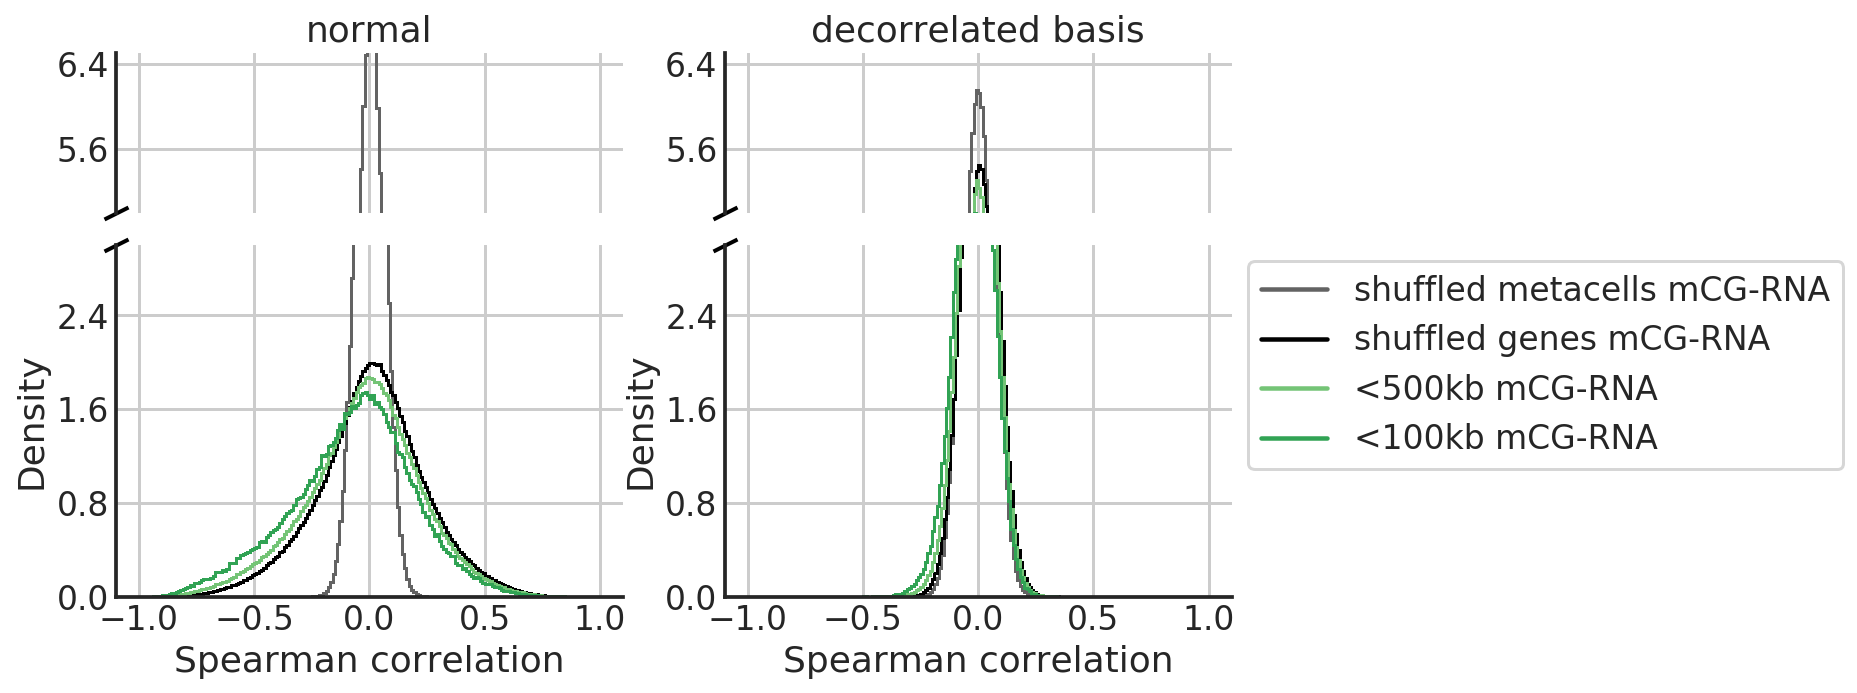

In [18]:
plot_routine(res_corrs_all['ols_spearman_mcrna'], 
             res_corrs_all['gls_spearman_mcrna'], 
             'normal', 'decorrelated basis', 'Spearman', 
             ylim1=[5, 6.5], ylim2=[0, 3],
            )

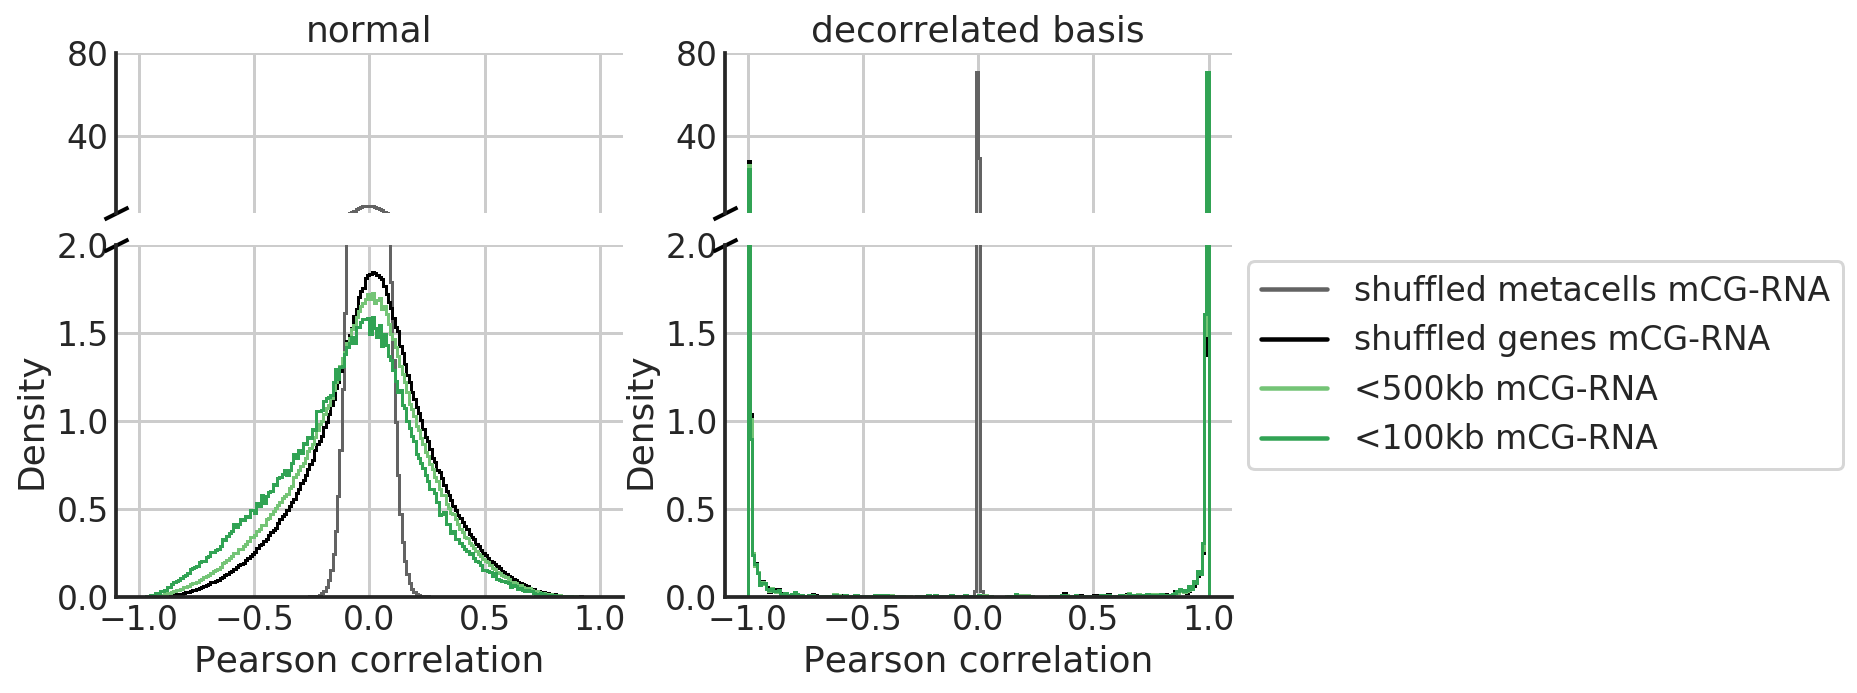

In [19]:
plot_routine(res_corrs_all['ols_pearson_mcrna'], 
             res_corrs_all['gls_pearson_mcrna'], 
             'normal', 'decorrelated basis', 'Pearson', 
             ylim1=[3, 80], ylim2=[0, 2],
            )

# Get some stats
- zoom in ; cdf ; Q-Q plot
- number of sig pairs

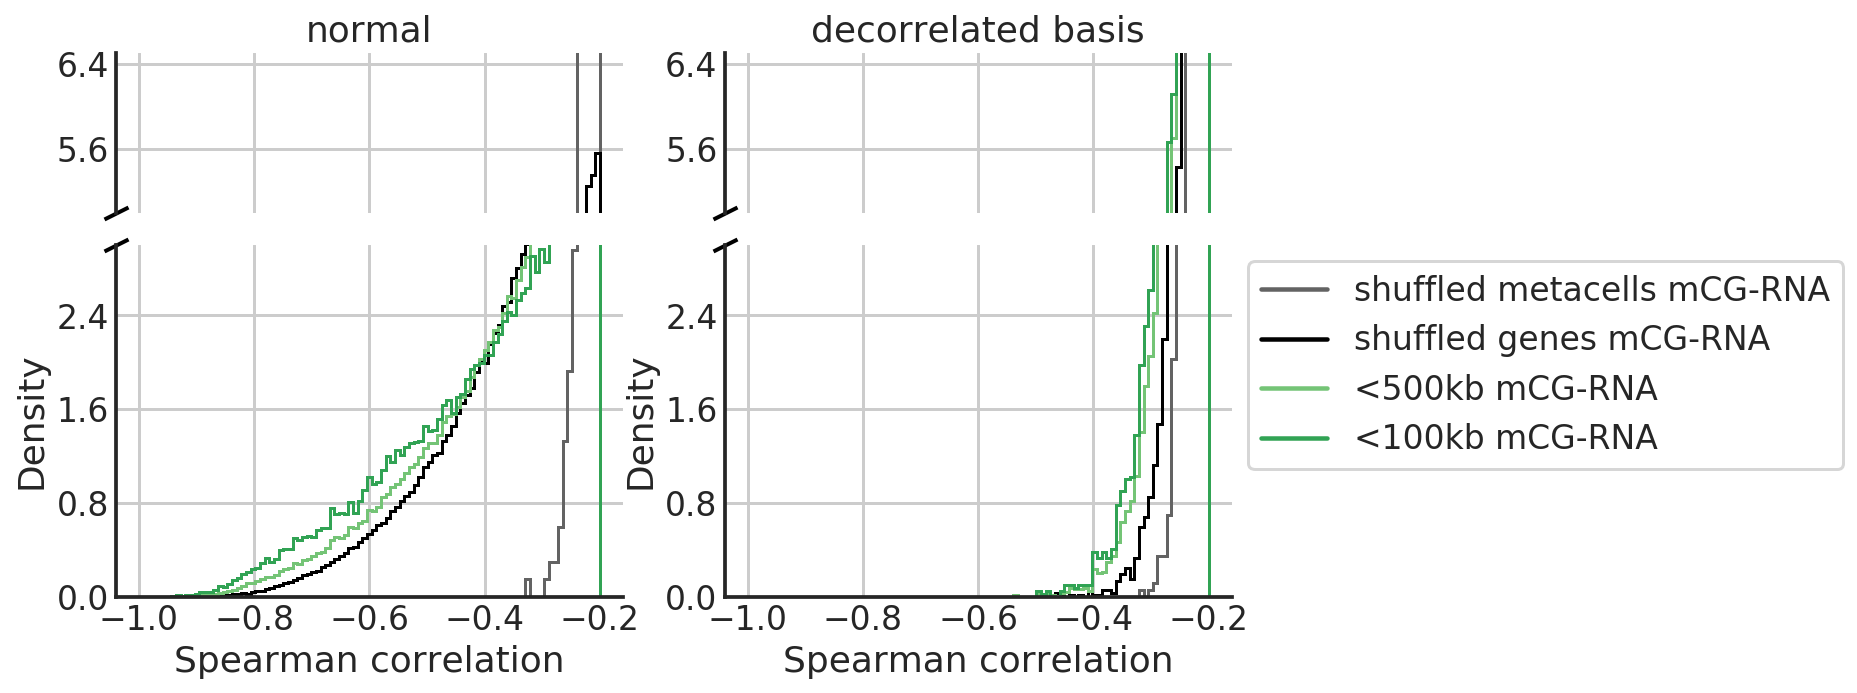

In [20]:
# zoom in 
plot_routine(res_corrs_all['ols_spearman_mcrna'], 
             res_corrs_all['gls_spearman_mcrna'], 
             'normal', 'decorrelated basis', 'Spearman', 
             ylim1=[5, 6.5], ylim2=[0, 3],
             bins=np.linspace(-1, -0.2, 100)
            )

In [21]:
def plot_routine_cdf(
                res_corrs1, res_corrs2, 
                title1, title2, corr_type, 
                ylim1=[], ylim2=[], 
                bins=np.linspace(-1, 1, 201),
                yscale='linear',
                output='',
                ):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharex=True, sharey=True)
    ax1, ax2 = axs
    for j, (res_corrs, title) in enumerate(zip([res_corrs1, res_corrs2], 
                                               [title1, title2],
                                          )):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+' mCG-RNA' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    
        ymax = 0
        ax = axs[j]
        for i, track in enumerate(corr_tracks):
            _y, _x = np.histogram(track, bins=bins, density=False)
            _x = _x[1:]
            ax.plot(_x, np.cumsum(_y)/np.sum(_y), '-', label=labels[i], color=colors[i])
            ymax = max(ymax, np.max(_y))
        _handles, _labels = ax.get_legend_handles_labels()
        ax.set_title(title)
        ax.set_yscale(yscale)
            
#     # limit number of y ticks
#     ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
#     ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
        
    ax1.set_xlabel('{} correlation'.format(corr_type))
    ax1.set_ylabel('Cumulative fraction of pairs')
    ax2.legend(_handles, _labels, bbox_to_anchor=(1,1))
    
    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    
    plt.show()
    return

In [22]:
def plot_routine_cdf_collapse(
                res_corrs1, res_corrs2, 
                title, corr_type, 
                ylim=[], 
                bins=np.linspace(-1, 1, 201),
                yscale='linear',
                output='',
                ):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    fig, ax = plt.subplots(1, 1, figsize=(6*1, 6),)
    linestyles = ['-', 'dashed']
    for j, (res_corrs) in enumerate(
        [res_corrs1, res_corrs2], 
        ):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+'' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    
        ymax = 0
        for i, track in enumerate(corr_tracks):
            _y, _x = np.histogram(track, bins=bins, density=False)
            _x = _x[1:]
            _y = np.cumsum(_y)/np.sum(_y)
            if len(ylim) > 0:
                _y = np.clip(_y, ylim[0], ylim[1])
            ax.plot(_x, _y, 
                    linewidth=3,
                    linestyle=linestyles[j], label=labels[i], color=colors[i])
        _handles, _labels = ax.get_legend_handles_labels()
        ax.set_title(title)
        ax.set_yscale(yscale)
        if len(ylim) > 0:
            ax.set_ylim(ylim)
            
#     # limit number of y ticks
#     ax.yaxis.set_major_locator(mtick.MaxNLocator(2))
        
    ax.set_xlabel('{} correlation'.format(corr_type))
    ax.set_ylabel('Cumulative fraction of pairs')
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1), ncol=2)
    
    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    
    plt.show()
    return

In [23]:
def plot_routine_qqplot_collapse(
                res_corrs1, res_corrs2, 
                title, corr_type, 
                ylim=[], 
                bins=np.linspace(-1, 1, 201),
                yscale='linear',
                output='',
                ):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    fig, ax = plt.subplots(1, 1, figsize=(6*1, 6),)
    linestyles = ['-', 'dashed']
    for j, (res_corrs) in enumerate(
        [res_corrs1, res_corrs2], 
        ):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+'' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    
        ymax = 0
        for i, track in enumerate(corr_tracks):
            _y, _x = np.histogram(track, bins=bins, density=False)
            _x = _x[1:]
            _y = np.cumsum(_y)/np.sum(_y)
            if len(ylim) > 0:
                _y = np.clip(_y, ylim[0], ylim[1])
            ax.plot(_x, _y, 
                    linewidth=3,
                    linestyle=linestyles[j], label=labels[i], color=colors[i])
        _handles, _labels = ax.get_legend_handles_labels()
        ax.set_title(title)
        ax.set_yscale(yscale)
        if len(ylim) > 0:
            ax.set_ylim(ylim)
            
#     # limit number of y ticks
#     ax.yaxis.set_major_locator(mtick.MaxNLocator(2))
        
    ax.set_xlabel('{} correlation'.format(corr_type))
    ax.set_ylabel('Cumulative fraction of pairs')
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1), ncol=2)
    
    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    
    plt.show()
    return

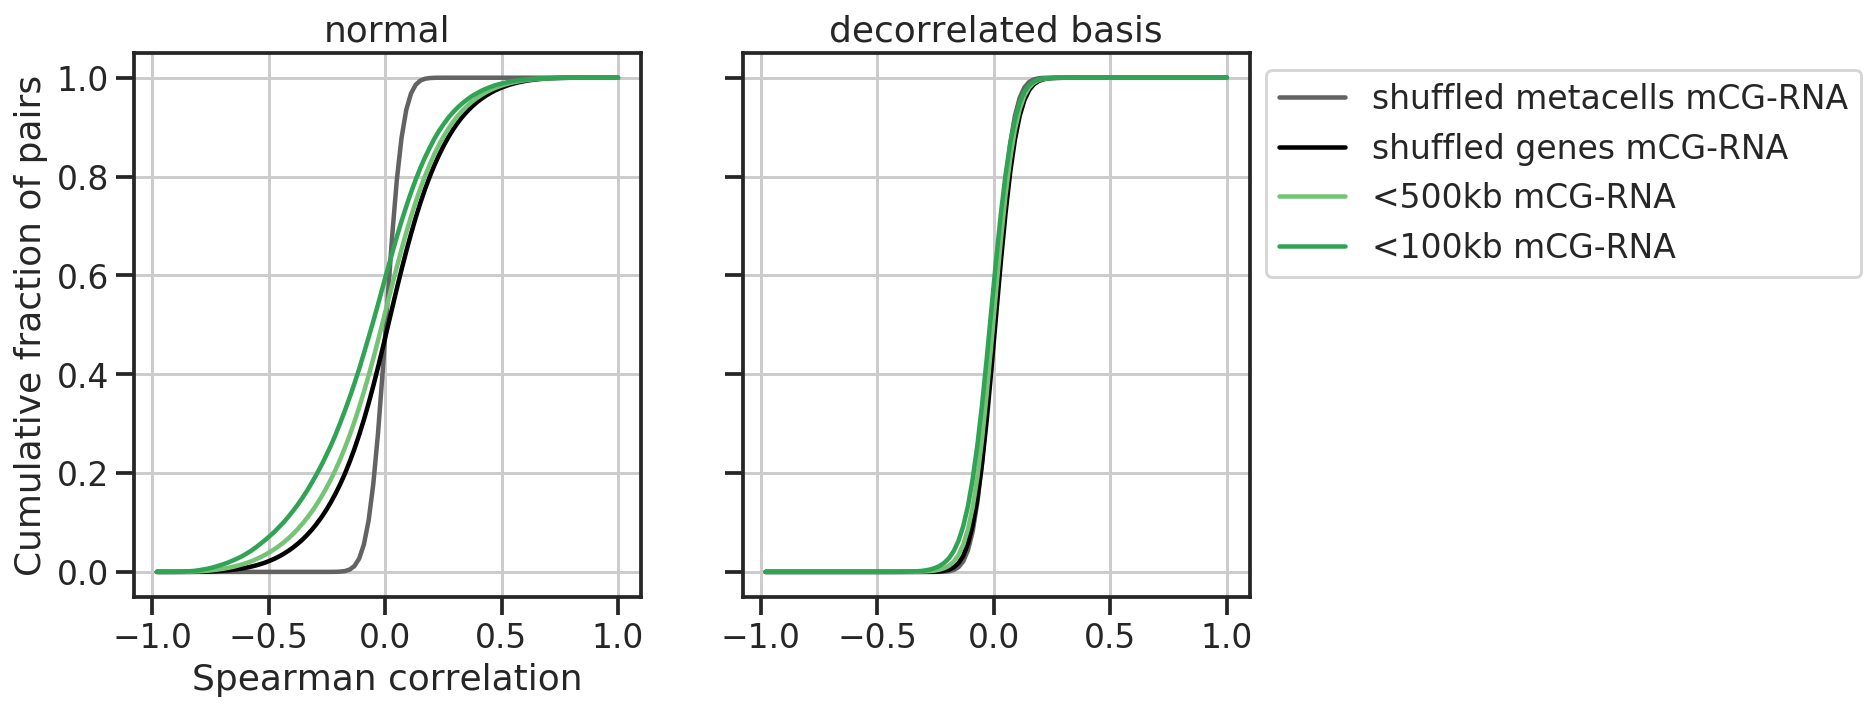

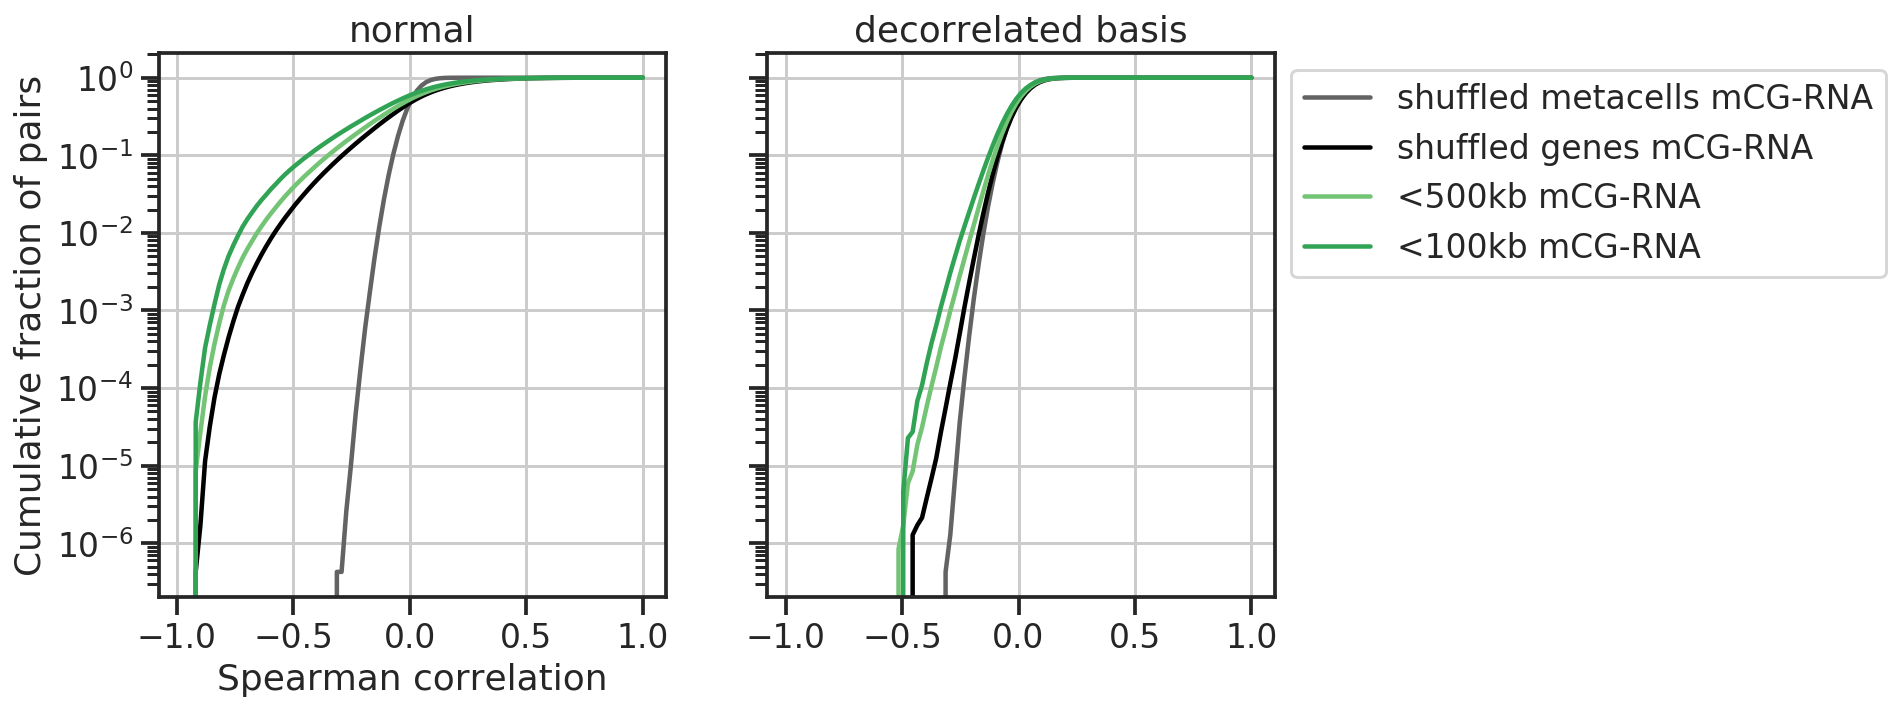

In [24]:
# cdf
plot_routine_cdf(res_corrs_all['ols_spearman_mcrna'], 
                 res_corrs_all['gls_spearman_mcrna'], 
                 'normal', 'decorrelated basis', 'Spearman', 
                 bins=np.linspace(-1, 1, 100),
                )

plot_routine_cdf(res_corrs_all['ols_spearman_mcrna'], 
                 res_corrs_all['gls_spearman_mcrna'], 
                 'normal', 'decorrelated basis', 'Spearman', 
                 bins=np.linspace(-1, 1, 100),
                 yscale='log'
                )

/cndd2/fangming/projects/scf_enhancers/figures/cdf_OLS2GLS_2021-03-18.pdf


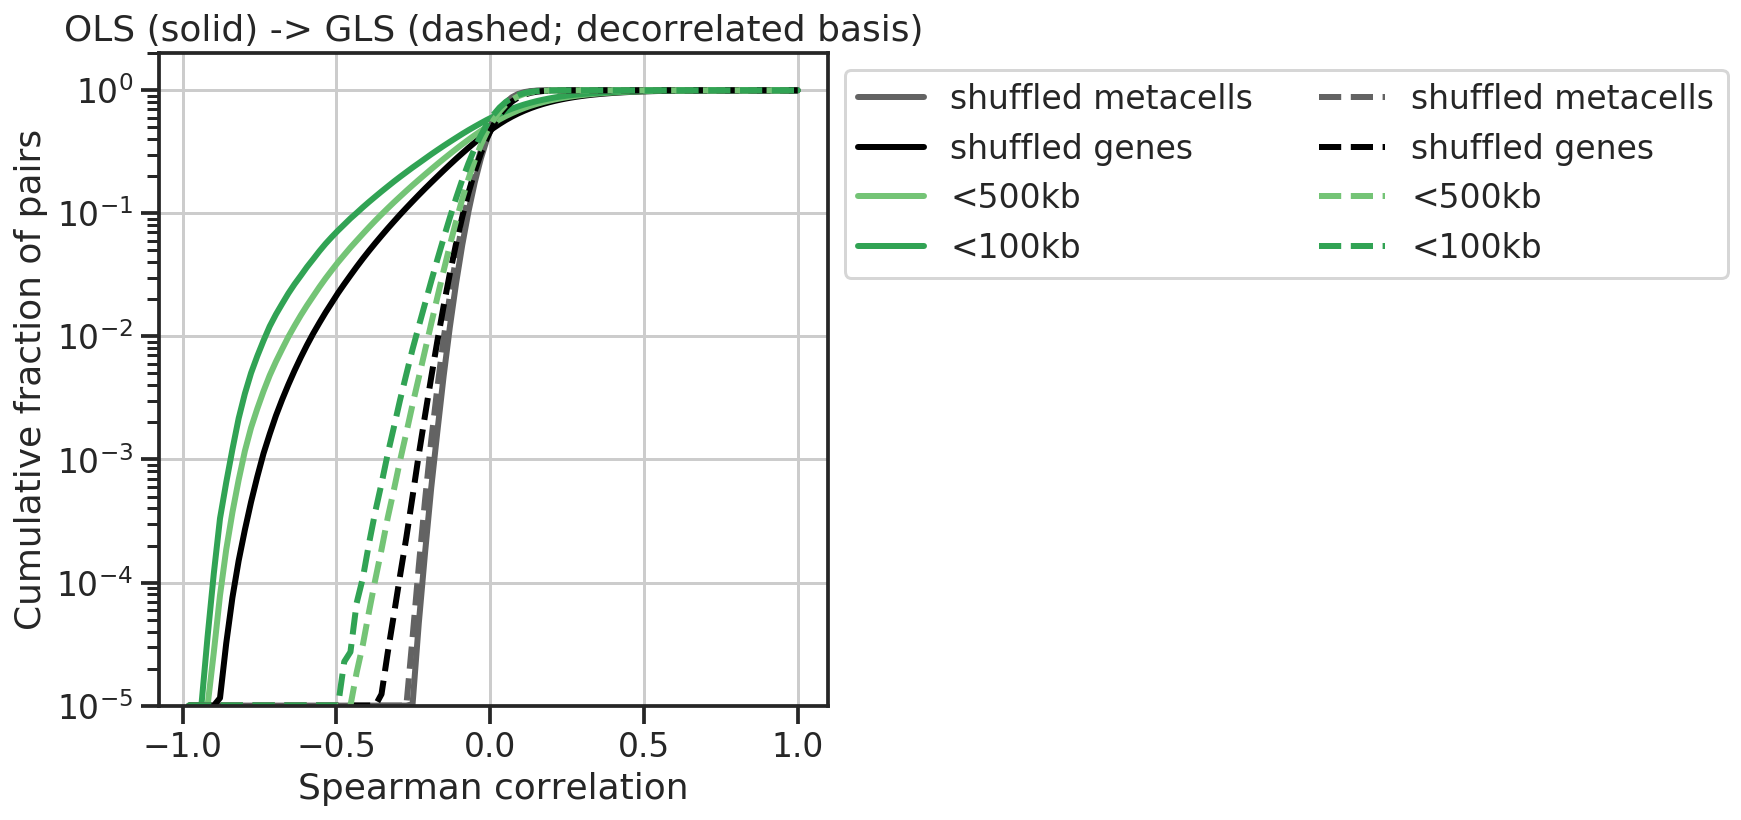

In [25]:
plot_routine_cdf_collapse(
                 res_corrs_all['ols_spearman_mcrna'], 
                 res_corrs_all['gls_spearman_mcrna'], 
                 'OLS (solid) -> GLS (dashed; decorrelated basis)', 
                 'Spearman', 
                 ylim=[1e-5, 2],
                 bins=np.linspace(-1, 1, 100),
                 yscale='log',
                 output=output_figformat.format("cdf_OLS2GLS")
                )

In [ ]:
# Q-Q plot
# stats

In [ ]:
# Q-Q plot

np.log()